# Postprocessing

The Isoforce data is recorded using three different channels named:

- **P** $\rightarrow \quad \text{Position}$ `AI0`
- **T** $\rightarrow \quad \text{Torque}$ `AI1`
- **S** $\rightarrow \quad \text{Speed}$ `AI2`

During the postprocessing, the global parameter name is used as follows with the corresponding class.

- **P** $\rightarrow \quad \text{Angle}$ `AI0` $\rightarrow$ `IsoforceIso.angle` colored in red (C3)
- **T** $\rightarrow \quad \text{Torque}$ `AI1` $\rightarrow$ `IsoforceIso.torque` colored in blue (C0)
- **S** $\rightarrow \quad \text{Speed}$ `AI2` $\rightarrow$ `IsoforceIso.speed` colored in yellow (C8)

**Set data path**

In [347]:
path = "data/raw_data/P15/"

## Start postprocessing

- `isoforce_iso` contains the data recorded with the Isoforce
- `isoforce_py_raw` contains the Isoforce data recorded with the Python script
- `sciospec_EIT_raw` contains the EIT data recorded with the EIT device

In [348]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from tools import (
    IsoforceIso,
    IsoforcePy,
    Protocol,
    ProcessingDir,
    process_sciospec_eit,
    renderDF,
    scale_to_range,
)

In [349]:
part_path = ProcessingDir(path)

protocol = Protocol(part_path.path, prints=False)
print(protocol.Participant.leg)
print(protocol.IsokinetikMeasurement.force_levels)

Fund participant data:

Head directory: self.path='data/raw_data/P15/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P15/EIT_P15_raw_data_12012025091939.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P15/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P15/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P15/eit_raw/20250207 08.55.42/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P15/EIT_processed/'
right
[60 60 50 50 20 20 30 30 80 80 70 70 40 40]


In [350]:
DF = renderDF(part_path.isoforce_iso)

!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


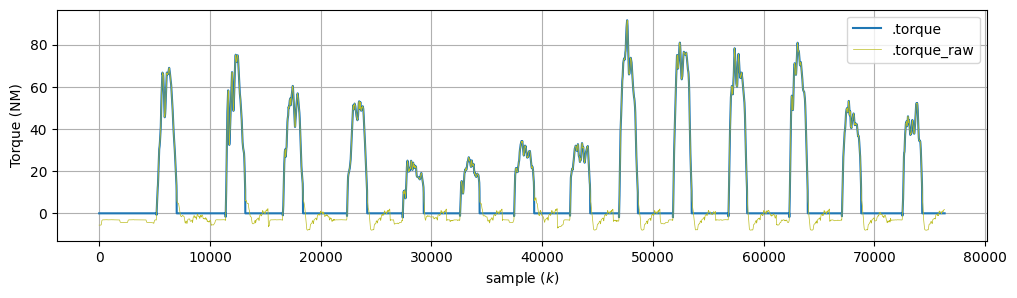

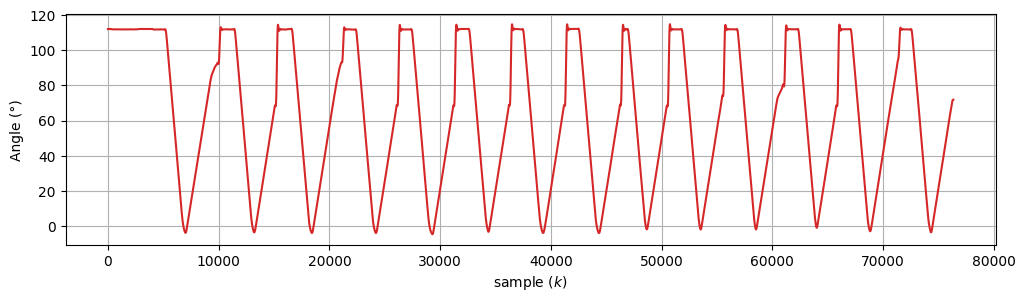

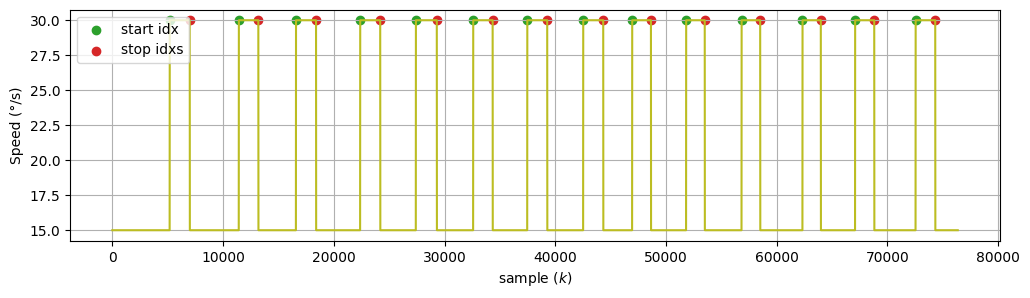

In [351]:
isoforce_iso = IsoforceIso(DF, protocol, LP_filter=True)
isoforce_iso.plot_torque()
isoforce_iso.plot_angle()
isoforce_iso.plot_speed()

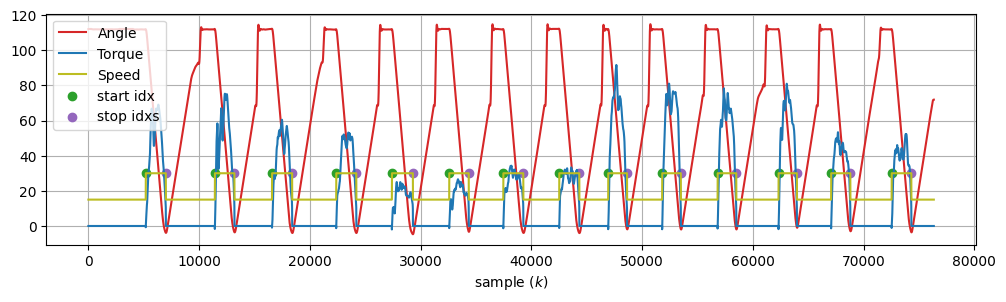

In [352]:
isoforce_iso.plot_data()

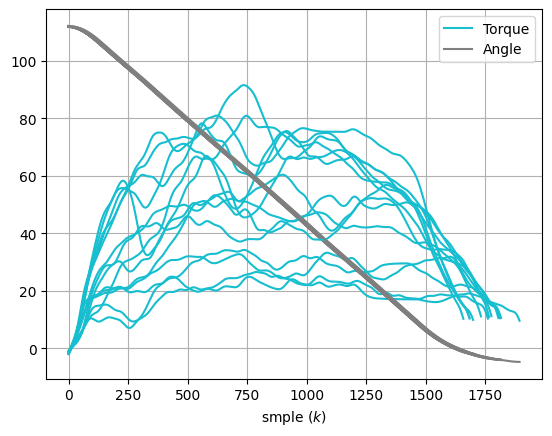

In [353]:
for idx in range(len(isoforce_iso.torque_segments.keys())):
    plt.plot(isoforce_iso.torque_segments[f"T_seg_{idx}"], "C9")
    plt.plot(isoforce_iso.angle_segments[f"A_seg_{idx}"], "C7")
plt.grid()
plt.legend(["Torque", "Angle"])
plt.xlabel("smple ($k$)")
plt.show()

**Isoforce Python raw**

- Ch_1, P = Angle = red (C3) {Factor = 54, Offset = 12}
- Ch_2, T = Torque = blue (C0) {Factor = 150, Offset = 24}
- Ch_3, S = Speed = yellow (C8) {Factor = 108, Offset = -4}

In [354]:
part_path.isoforce_py_raw

'data/raw_data/P15/iso_raw/'

In [355]:
isoforce_py = IsoforcePy(
    part_path.isoforce_py_raw,
    protocol,
    LP_filter=True,
    over_UTC=False,
    scale_0_1=True,
    segment_len_threshold=105,
)

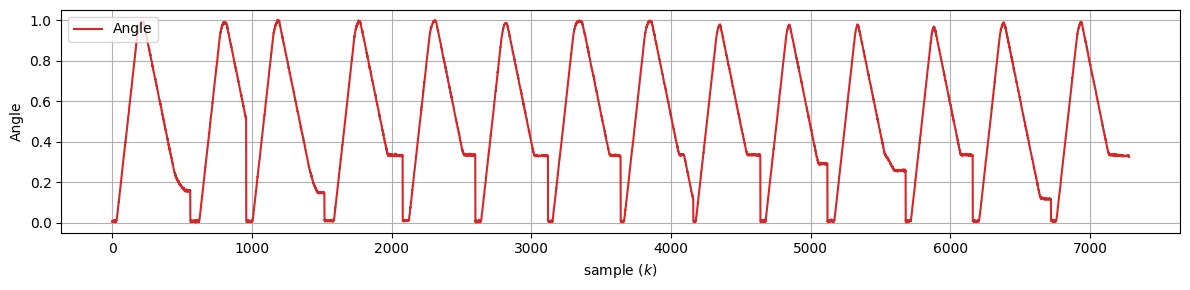

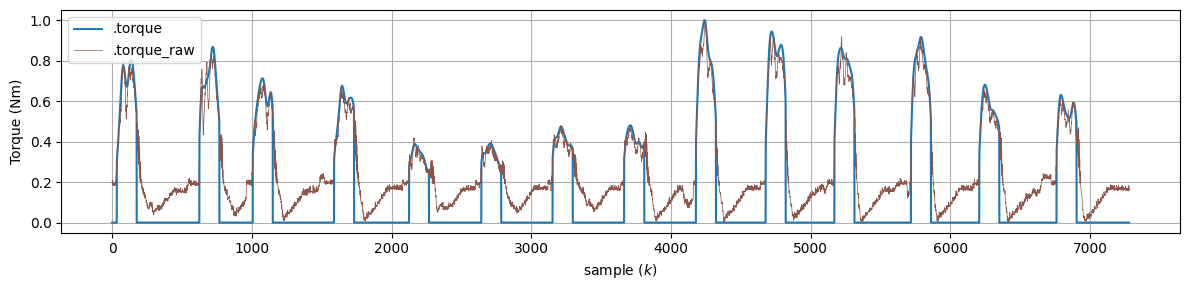

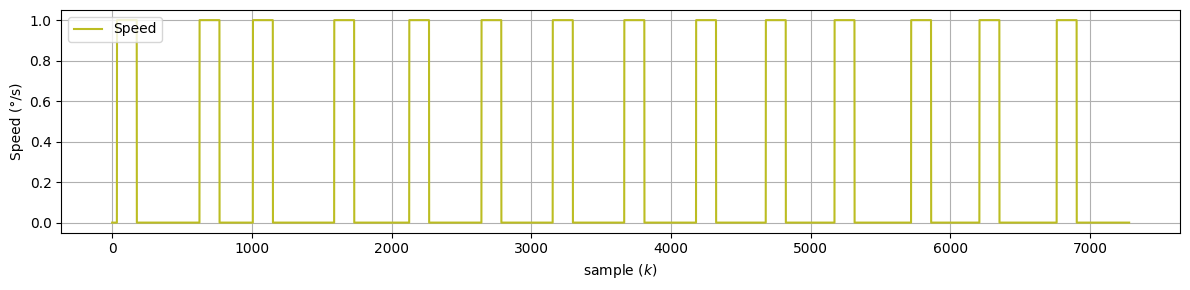

In [356]:
isoforce_py.plot_angle()
isoforce_py.plot_torque()
isoforce_py.plot_speed()

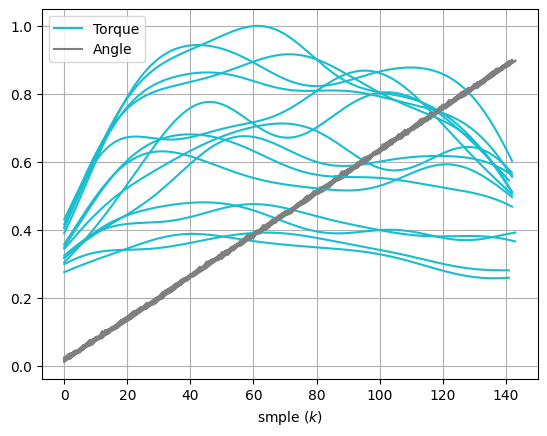

In [357]:
for idx in range(len(isoforce_py.torque_segments.keys())):
    plt.plot(isoforce_py.torque_segments[f"T_seg_{idx}"], "C9")
    plt.plot(isoforce_py.angle_segments[f"A_seg_{idx}"], "C7")
plt.grid()
plt.legend(["Torque", "Angle"])
plt.xlabel("smple ($k$)")
plt.show()

**Sync `isoforce_iso` with `isoforce_py`**

In [358]:
len(isoforce_iso.torque_segments.keys()), len(isoforce_py.torque_segments.keys())

(14, 14)

In [359]:
from scipy.signal import resample


def resample_signals(iso_iso, iso_py, target_length=None):
    iso_iso = np.asarray(iso_iso)
    iso_py = np.asarray(iso_py)
    if target_length:
        print(f"Resample both signals to a length of {target_length} samples.")
        iso_py = resample(iso_py, num=target_length)
        iso_iso = resample(iso_iso, num=target_length)
        return iso_iso, iso_py
    else:
        target_length = max(len(iso_iso), len(iso_py))
        print(f"Resample both signals to a length of {target_length} samples.")
        if len(iso_iso) > len(iso_py):
            iso_py = resample(iso_py, num=target_length)
        elif len(iso_py) > len(iso_iso):
            iso_iso = resample(iso_iso, num=target_length)
        return iso_iso, iso_py


def detect_shift(signal1, signal2):
    N = max(len(signal1), len(signal2))
    corr = np.correlate(signal1, signal2, mode="full")
    lags = np.arange(-N + 1, N)

    max_corr_idx = np.argmax(corr)
    discrete_time_shift = lags[max_corr_idx]
    print(f"Discrete time shift of {discrete_time_shift}.")
    return discrete_time_shift

Resample both signals to a length of 1813 samples.
Discrete time shift of -57.
Resample both signals to a length of 1500 samples.


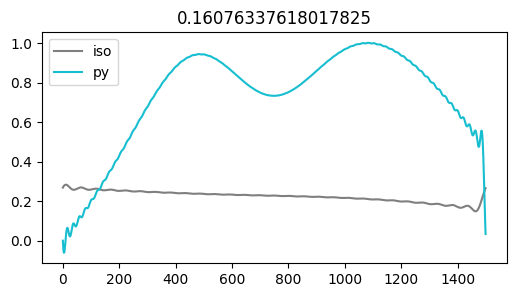

Resample both signals to a length of 1767 samples.
Discrete time shift of -40.
Resample both signals to a length of 1500 samples.


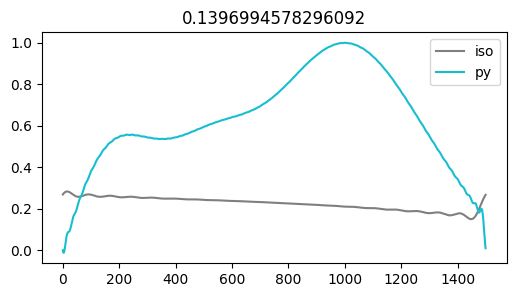

Resample both signals to a length of 1817 samples.
Discrete time shift of -71.
Resample both signals to a length of 1500 samples.


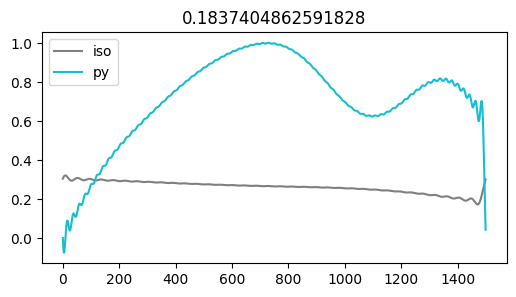

Resample both signals to a length of 1814 samples.
Discrete time shift of -64.
Resample both signals to a length of 1500 samples.


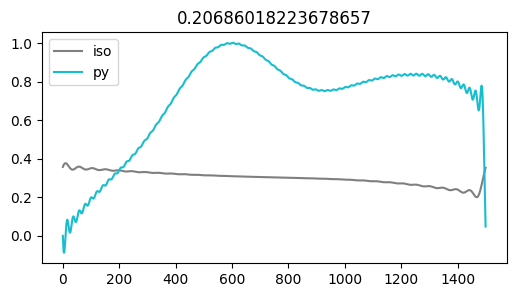

Resample both signals to a length of 1895 samples.
Discrete time shift of 213.
Resample both signals to a length of 1500 samples.


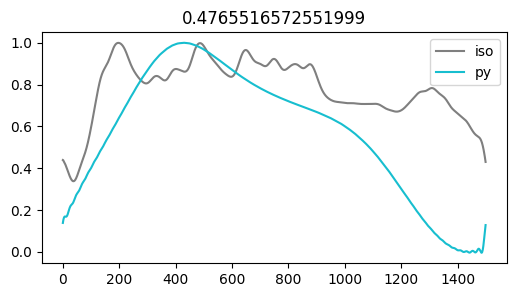

Resample both signals to a length of 1762 samples.
Discrete time shift of 196.
Resample both signals to a length of 1500 samples.


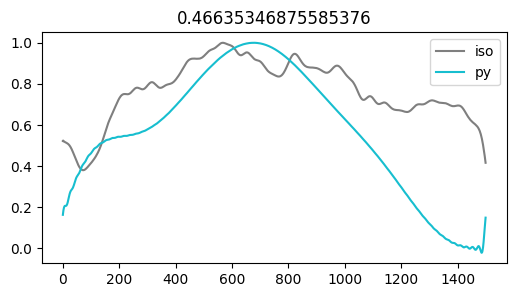

Resample both signals to a length of 1806 samples.
Discrete time shift of 10.
Resample both signals to a length of 1500 samples.


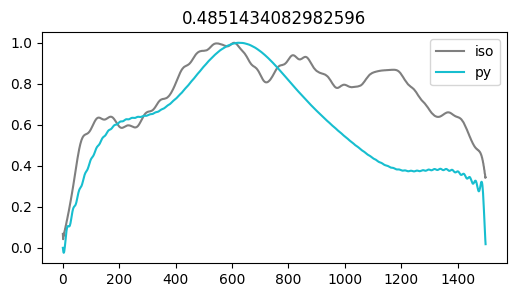

Resample both signals to a length of 1814 samples.
Discrete time shift of 7.
Resample both signals to a length of 1500 samples.


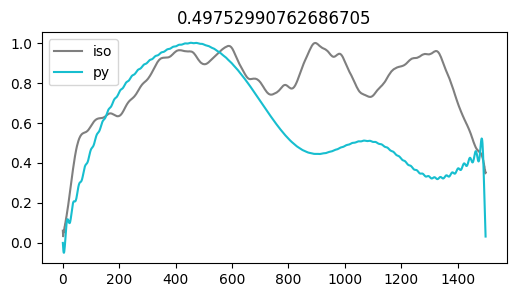

Resample both signals to a length of 1700 samples.
Discrete time shift of -1.
Resample both signals to a length of 1500 samples.


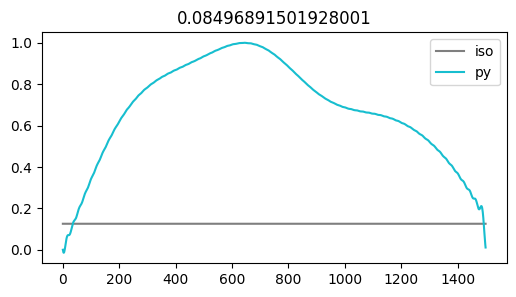

Resample both signals to a length of 1685 samples.
Discrete time shift of -25.
Resample both signals to a length of 1500 samples.


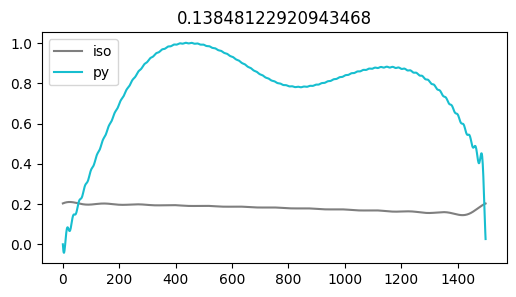

Resample both signals to a length of 1685 samples.
Discrete time shift of -5.
Resample both signals to a length of 1500 samples.


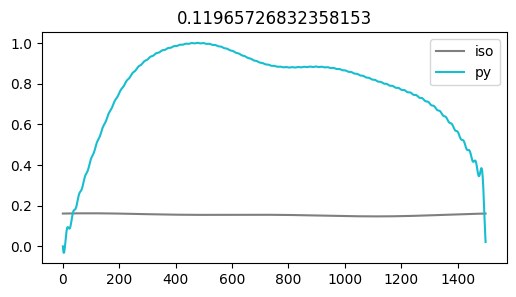

Resample both signals to a length of 1659 samples.
Discrete time shift of 3.
Resample both signals to a length of 1500 samples.


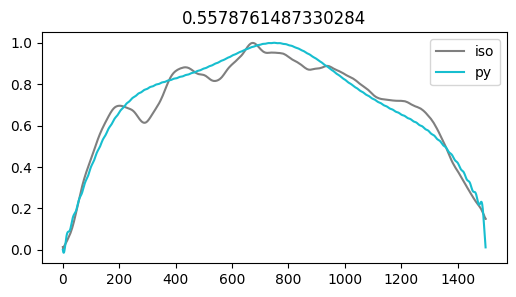

Resample both signals to a length of 1733 samples.
Discrete time shift of 7.
Resample both signals to a length of 1500 samples.


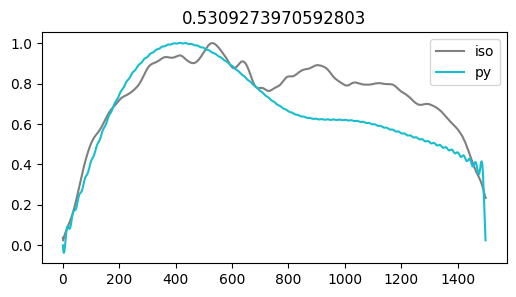

Resample both signals to a length of 1777 samples.
Discrete time shift of -4.
Resample both signals to a length of 1500 samples.


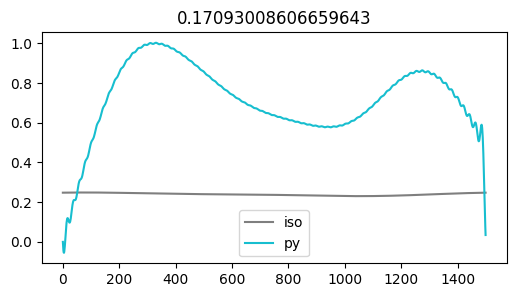

In [360]:
for idx in range(
    min(
        len(isoforce_iso.torque_segments.keys()),
        len(isoforce_py.torque_segments.keys()),
    )
):
    # scale the amplitude rage to [0,1].
    iso_seg = scale_to_range(isoforce_iso.torque_segments[f"T_seg_{idx}"])
    py_seg = scale_to_range(isoforce_py.torque_segments[f"T_seg_{idx}"])
    # create two signals of same length and compute the phase shift.
    iso_seg_corr, py_seg_corr = resample_signals(iso_seg, py_seg)
    shift = detect_shift(iso_seg_corr, py_seg_corr)
    # resample the original, amplitude scaled signals to a constant lenght
    iso_seg, py_seg = resample_signals(iso_seg[shift:], py_seg, target_length=1500)

    plt.figure(figsize=(6, 3))
    plt.title(np.correlate(iso_seg, py_seg)[0] / len(iso_seg))
    # plt.show()
    plt.plot(iso_seg, "C7", label="iso")
    plt.plot(py_seg, "C9", label="py")
    plt.legend()
    plt.show()

In [361]:
for start, stop in zip(isoforce_py.start_idxs, isoforce_py.stop_idxs):
    print("from", isoforce_py.time[start], "to", isoforce_py.time[stop])
    print("Δt", isoforce_py.time[stop] - isoforce_py.time[start])

from 2025-02-07 08:55:46.850000 to 2025-02-07 08:55:50.400000
Δt 0:00:03.550000
from 2025-02-07 08:56:41.625000 to 2025-02-07 08:56:45.200000
Δt 0:00:03.575000
from 2025-02-07 08:57:31.175000 to 2025-02-07 08:57:34.750000
Δt 0:00:03.575000
from 2025-02-07 08:58:22.725000 to 2025-02-07 08:58:26.300000
Δt 0:00:03.575000
from 2025-02-07 08:59:14.150000 to 2025-02-07 08:59:17.700000
Δt 0:00:03.550000
from 2025-02-07 09:00:02.075000 to 2025-02-07 09:00:05.625000
Δt 0:00:03.550000
from 2025-02-07 09:00:56.825000 to 2025-02-07 09:01:00.425000
Δt 0:00:03.600000
from 2025-02-07 09:01:46.625000 to 2025-02-07 09:01:50.225000
Δt 0:00:03.600000
from 2025-02-07 09:02:34.475000 to 2025-02-07 09:02:38.050000
Δt 0:00:03.575000
from 2025-02-07 09:03:28.950000 to 2025-02-07 09:03:32.525000
Δt 0:00:03.575000
from 2025-02-07 09:04:15.250000 to 2025-02-07 09:04:18.825000
Δt 0:00:03.575000
from 2025-02-07 09:05:04.950000 to 2025-02-07 09:05:08.525000
Δt 0:00:03.575000
from 2025-02-07 09:05:59.175000 to 2025-

**EIT Sciospec raw**

In [362]:
part_path = ProcessingDir(path)

Fund participant data:

Head directory: self.path='data/raw_data/P15/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P15/EIT_P15_raw_data_12012025091939.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P15/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P15/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P15/eit_raw/20250207 08.55.42/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P15/EIT_processed/'


In [363]:
part_path.print_info()

Fund participant data:

Head directory: self.path='data/raw_data/P15/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P15/EIT_P15_raw_data_12012025091939.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P15/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P15/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P15/eit_raw/20250207 08.55.42/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P15/EIT_processed/'


In [364]:
part_path.s_path_eit

'data/raw_data/P15/EIT_processed/'

In [ ]:
try:
    os.mkdir(part_path.s_path_eit)
    process_sciospec_eit(part_path, protocol)
except BaseException:
    print("Directory already exists.")

In [ ]:
tmp = np.load(part_path.s_path_eit + "setup_00002.npz", allow_pickle=True)
tmp_2 = np.load(part_path.s_path_eit + "setup_00003.npz", allow_pickle=True)
tmp.files

plt.title(tmp["timestamp"])
plt.imshow(np.abs(tmp["eit"]))
plt.show()

In [ ]:
times = list()
for ele in np.sort(glob(part_path.s_path_eit + "*.npz")):
    tmp = np.load(ele, allow_pickle=True)
    times.append(tmp["timestamp"])
times = np.array(times)

In [ ]:
time_py = [dt.timestamp() for dt in isoforce_py.time]

plt.figure(figsize=(6, 3))
plt.plot(times, times, ".", label="time EIT device")
plt.plot(time_py, time_py, ".", label="time python data")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(len(time_py))
print(len(times))

**Load eit and color time in PCA**

In [25]:
EIT = list()
for ele in np.sort(glob(part_path.s_path_eit + "*.npz")):
    tmp = np.load(ele, allow_pickle=True)
    EIT.append(tmp["eit"])
EIT = np.asarray(EIT)
EIT = np.abs(EIT)

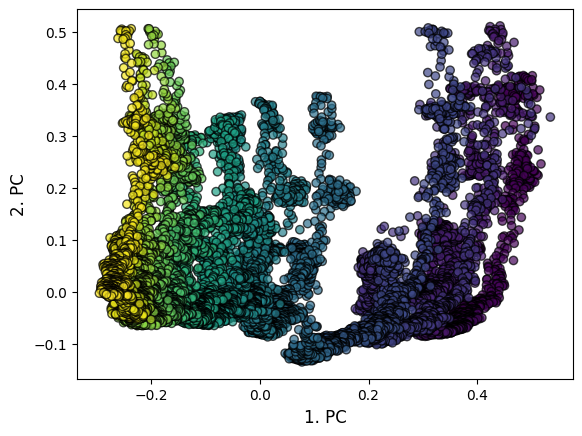

In [26]:
from sklearn.decomposition import PCA

data_flattened = EIT.reshape(EIT.shape[0], -1)
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(data_flattened)

plt.scatter(
    data_reduced[:, 0],
    data_reduced[:, 1],
    c=scale_to_range(times),
    edgecolor="k",
    alpha=0.7,
)
plt.xlabel("1. PC", fontsize=12)
plt.ylabel("2. PC", fontsize=12)
plt.show()

## Preprocess eit

In [ ]:
from tools import (
    ProcessingDir,
    process_sciospec_eit,
)

for p in range(1, 16):
    path = "data/raw_data/P{0:02d}/".format(p)
    part_path = ProcessingDir(path)

    try:
        os.mkdir(part_path.s_path_eit)
        process_sciospec_eit(part_path, protocol)
    except BaseException:
        print("Directory already exists.")

In [346]:
from glob import glob
from os.path import join
import os

import numpy as np

for path1 in np.sort(glob("data/raw_data/P*")):
    path2 = join(path1, "EIT_processed")
    print(path1, len(os.listdir(path2)))

data/raw_data/P01 34358
data/raw_data/P02 28240
data/raw_data/P03 30269
data/raw_data/P04 30030
data/raw_data/P05 30639
data/raw_data/P06 33558
data/raw_data/P07 29315
data/raw_data/P08 29851
data/raw_data/P09 29546
data/raw_data/P10 32077
data/raw_data/P11 33787
data/raw_data/P12 30422
data/raw_data/P13 29774
data/raw_data/P14 30522


FileNotFoundError: [Errno 2] No such file or directory: 'data/raw_data/P15/EIT_processed'

___